In [35]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, TruncatedSVD
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

%matplotlib inline

In [14]:
input_path = '../joke_recommender/data/'
df = pd.read_csv(input_path + 'joke_dataframe.csv')
df = df.drop(['Unnamed: 0', 'JokeId'], axis = 1)
df

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User73412,User73413,User73414,User73415,User73416,User73417,User73418,User73419,User73420,User73421
0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,-7.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,-5.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,-3.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,-1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,4.03,...,3.64,4.32,6.99,-9.66,-8.4,-0.63,9.51,-7.67,-1.6,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.31,-1.02,3.98,3.93,9.13,1.94,0.44,1.21,6.94,1.12,...,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,-4.95,-0.97,-6.46,-2.57,9.17,1.99,-0.78,5.34,5.83,0.78,...,NaN,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN
97,-0.19,4.13,-6.89,1.07,9.17,3.45,-1.02,1.94,5.53,4.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,3.25,-1.84,-2.33,2.33,9.08,9.17,1.70,3.06,6.55,7.86,...,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
X = np.array(df)
scaler = MinMaxScaler(feature_range=(1,2))
scaler.fit(X)
X_transform = scaler.transform(X)
X = np.nan_to_num(X_transform)
X

array([[1.77986437, 1.06564799, 1.33225458, ..., 0.        , 0.        ,
        0.        ],
       [1.7694314 , 1.51386531, 1.36407767, ..., 0.        , 0.        ,
        0.        ],
       [1.60511215, 1.67572156, 1.403452  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.50391236, 1.79683079, 1.14940669, ..., 0.        , 0.        ,
        0.        ],
       [1.68335942, 1.45897001, 1.39536138, ..., 0.        , 0.        ,
        0.        ],
       [1.74178404, 1.73061686, 1.12297735, ..., 0.        , 0.        ,
        0.        ]])

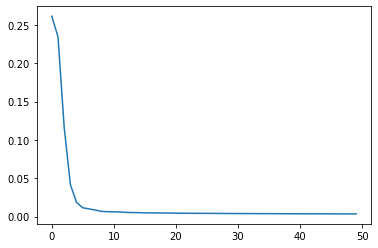

In [16]:
svd = TruncatedSVD(n_components=50)
svd.fit(X)
evr = svd.explained_variance_ratio_
sns.lineplot(x = range(0,50), y = evr)

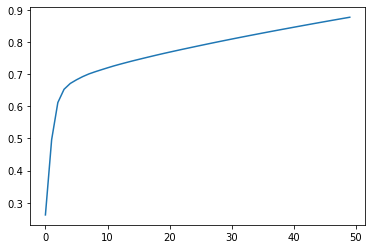

In [17]:
evr_sum = np.cumsum(evr)
sns.lineplot(x = range(0,50), y = evr_sum)

In [18]:
evr_sum

array([0.26147585, 0.49595488, 0.61198758, 0.65335751, 0.67155726,
       0.68295003, 0.69286423, 0.70129417, 0.70802742, 0.71424908,
       0.72032346, 0.72619471, 0.73156218, 0.73672047, 0.7417631 ,
       0.74653597, 0.75127141, 0.75592001, 0.76052078, 0.76500697,
       0.76932763, 0.77362007, 0.77784828, 0.7819828 , 0.78611222,
       0.79021048, 0.79428641, 0.79829089, 0.80224777, 0.8061654 ,
       0.81005974, 0.81390711, 0.81771105, 0.82146799, 0.82519954,
       0.82892084, 0.83259136, 0.83623373, 0.83983991, 0.84341525,
       0.84698077, 0.85053934, 0.85406007, 0.85756782, 0.86104591,
       0.86450599, 0.86794405, 0.87135341, 0.87473551, 0.87811306])

In [19]:
#We chose a evr_sum of 0.8
np.where(np.logical_and (evr_sum > 0.79, evr_sum < 0.81)) 

(array([25, 26, 27, 28, 29]),)

In [20]:
#We chose 28 principal components

In [21]:
opt_svd = TruncatedSVD(n_components=2)
opt_svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
# df2 = df.head(2)
# corr = df2.corr()
# ax = sns.heatmap(corr, vmin = 1, vmax = 2, center = 0, cmap=sns.diverging_palette(20,220,n=200), square = True);

IndexError: index 7423 is out of bounds for axis 1 with size 300

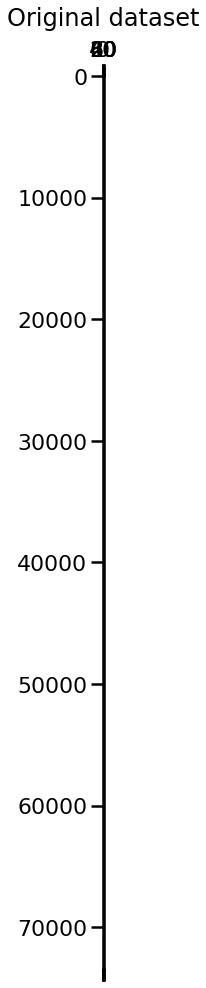

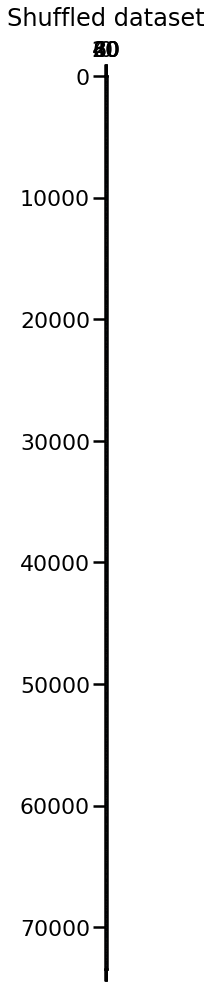